## Introduction

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds
import keras

## Get the Data

In [2]:
train_data, validation_data, test_data = tfds.load("imdb_reviews",
                                                   split=['train[:70%]', 'train[-30%:]', 'test'],
                                                   as_supervised=True)

## Explore the Data

In [3]:
train_examples_batch, train_labels_batch = next(iter(train_data.batch(2)))

In [4]:
train_examples_batch

<tf.Tensor: shape=(2,), dtype=string, numpy=
array([b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it.",
       b'I have been known to fall asleep during films, but this is usually due to a combination of things including, really tired, being warm and comfortable on the sette and having just eaten a lot. However on this occasion I fell a

In [5]:
train_labels_batch

<tf.Tensor: shape=(2,), dtype=int64, numpy=array([0, 0], dtype=int64)>

## Build the Model

In [6]:
embedding = "https://tfhub.dev/google/nnlm-en-dim128-with-normalization/2"
hub_layer = hub.KerasLayer(embedding, dtype = tf.string, input_shape=[], trainable=False)

model = keras.Sequential([
    hub_layer,
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(32, activation='relu', kernel_regularizer=keras.regularizers.l2(0.075)),
    keras.layers.Dense(16, activation='relu'),
    keras.layers.Dropout(0.55),
    keras.layers.Dense(1, activation='sigmoid')
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 128)               124642688 
_________________________________________________________________
dense (Dense)                (None, 128)               16512     
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_3 (Dense)              (None, 16)                528       
_________________________________________________________________
dropout (Dropout)            (None, 16)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 1

## Compile the Model

In [7]:
model.compile(loss = tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(0.01),
              metrics=tf.keras.metrics.BinaryAccuracy())

## Train the Model

In [8]:
def scheduler(epoch, lr):
    if epoch < 5:
        return lr
    else:
        return lr*tf.math.exp(-0.1)

In [9]:
from keras import callbacks

earlystopping = callbacks.EarlyStopping(monitor='val_binary_accuracy',
                                        mode='max',
                                        patience=10,
                                        restore_best_weights=True,
                                        verbose=1)

lr_scheduler = callbacks.LearningRateScheduler(scheduler, verbose=1)

In [10]:
batch_size=512
train_data = train_data.shuffle(10000).batch(batch_size)
validation_data=validation_data.batch(batch_size)

history = model.fit(train_data,
                    validation_data = validation_data,
                    epochs=100,
                    verbose=1,
                    callbacks=[earlystopping, lr_scheduler])


Epoch 00001: LearningRateScheduler reducing learning rate to 0.009999999776482582.
Epoch 1/100
35/35 [==============================] - 3s 92ms/step - loss: 1.3016 - binary_accuracy: 0.5846 - val_loss: 0.6438 - val_binary_accuracy: 0.7709

Epoch 00002: LearningRateScheduler reducing learning rate to 0.009999999776482582.
Epoch 2/100
35/35 [==============================] - 3s 85ms/step - loss: 0.6215 - binary_accuracy: 0.7797 - val_loss: 0.6217 - val_binary_accuracy: 0.7921

Epoch 00003: LearningRateScheduler reducing learning rate to 0.009999999776482582.
Epoch 3/100
35/35 [==============================] - 3s 81ms/step - loss: 0.6106 - binary_accuracy: 0.7849 - val_loss: 0.6000 - val_binary_accuracy: 0.8099

Epoch 00004: LearningRateScheduler reducing learning rate to 0.009999999776482582.
Epoch 4/100
35/35 [==============================] - 2s 69ms/step - loss: 0.6028 - binary_accuracy: 0.7999 - val_loss: 0.5950 - val_binary_accuracy: 0.8021

Epoch 00005: LearningRateScheduler redu

In [11]:
model.save('sentiment_analysis')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: sentiment_analysis\assets
INFO:tensorflow:Assets written to: sentiment_analysis\assets


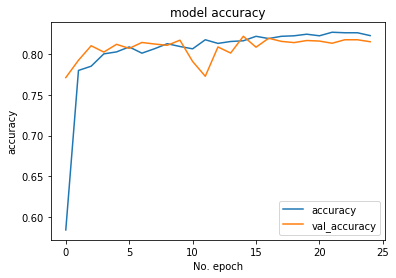

In [12]:
import matplotlib.pyplot as plt

plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('No. epoch')
plt.legend(['accuracy', 'val_accuracy'], loc='lower right')
plt.show()

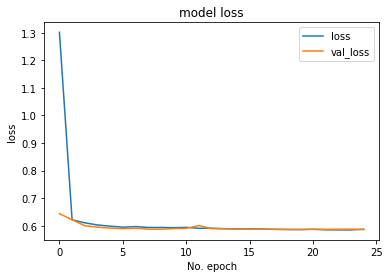

In [13]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('No. epoch')
plt.legend(['loss', 'val_loss'], loc='upper right')
plt.show()

## Evaluate the Model

In [14]:
results = model.evaluate(test_data.batch(512), verbose=2)

for name, value in zip(model.metrics_names, results):
  print("%s: %.3f" % (name, value))

49/49 - 4s - loss: 0.5901 - binary_accuracy: 0.8169
loss: 0.590
binary_accuracy: 0.817


In [15]:
sample_text = ("I enjoy going out and having a hike with friends")

model.predict(np.array([sample_text]))

array([[0.9955934]], dtype=float32)

In [16]:
test_data = tfds.load("imdb_reviews", split='test', shuffle_files=True, batch_size=-1)
test_df= pd.DataFrame(test_data)
test_df.head()

,label,text
0,1,"b""There are films that make careers. For Georg..."
1,1,"b""A blackly comic tale of a down-trodden pries..."
2,0,"b'Scary Movie 1-4, Epic Movie, Date Movie, Mee..."
3,0,b'Poor Shirley MacLaine tries hard to lend som...
4,1,b'As a former Erasmus student I enjoyed this f...


In [17]:
predictions = model.predict(test_df['text'])
predictions[0:5]

array([[9.8697615e-01],
       [9.9966121e-01],
       [9.9283999e-01],
       [2.5500125e-11],
       [9.9984610e-01]], dtype=float32)

In [18]:
def sentiment_category(sentiment_score):
    if sentiment_score <= 0.5:
        category=0
    else:
        category=1
    return category

In [19]:
from sklearn.metrics import classification_report

test_df['preds'] = predictions
test_df['preds']=test_df['preds'].apply(sentiment_category)
print(classification_report(test_df['label'], test_df['preds']))


              precision    recall  f1-score   support

           0       0.80      0.85      0.82     12500
           1       0.84      0.78      0.81     12500

    accuracy                           0.82     25000
   macro avg       0.82      0.82      0.82     25000
weighted avg       0.82      0.82      0.82     25000

